# GeoCluster Demo

This notebook contains a demo of the GeoCluster algorithm for a dataset of **1000 squares** (with rotation) in 2D space.

The metric used is `L_inf`, where the function is adjusted to calculate the `L_inf` distance between a square object and a point.

## Load libraries and data

Loading data...
Data loaded.


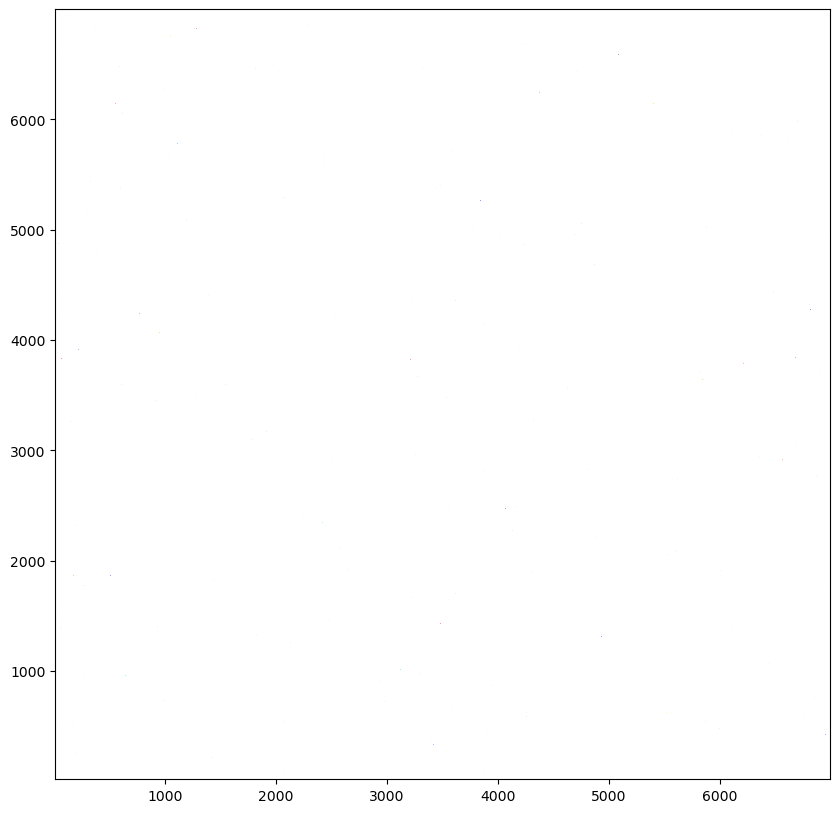

In [1]:
import torch
from src.k_tree import Ktree
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = loadSquares(10 ** 3)
pt.plot_data(data, limits=[min(data[:, 0]), max(data[:, 0]), min(data[:, 1]), max(data[:, 1])])

## Initialise k-tree with training parameters

In order to create the hierarchical clustering tree structure, we initialise a `Ktree` object which takes as parameters the training arguments for the *Clustering* and *Critic* models, as well as the arguments for the UN sampler.

In [2]:
k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 100,  # number of epochs
    "times": 10,  # number of times to print the training status (over the epochs)
    "alpha": 0.1,  # projection loss
    "beta": 0.1,  # latent loss
    "gamma": 0.011,  # repulsive loss
    "delta": 0.1,  # fuzzy scale
    "f_clk": 10,  # clock of applying the Gaussian sampler
    "scale": 1,  # scale of the noise
    "scale_flag": False,  # if True ignore the "scale" parameter and use the data length
    "number_of_centroids": k,
    "latent_size": 200,  # size of the latent space
    "encoder_activation": False,
    "encoder_depth": 5,
    "predictor_width": 5 * 100,
    "predictor_depth": 5,
}
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n ** 2 - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 3000,  # number of epochs
    "width": 200,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 300  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
ktree = Ktree(threshold, data, Linf_simple, clustering_args, un_args, critic_args, device)

## Create the k-tree

### Train the k-tree

Starting from the tree's root node, train the *Clustering* and *Critic* models, store the Critic model on the node and assign the data on its children according to the Critic's predictions.
Repeat recursively the process until a node has less amount of data than the threshold.

Also plot some training results and store them as well as the resulting models to files.


Creating critic for node 0 that has 999 data, which is more than the threshold 300.
Bounding box for node 0: [[3, 7004], [11, 7006]]
Creating clustering for node 0 with 3 centroids.
Training Clustering Model
Epoch: 10/100.. 
 Training loss: 2578.78589.. 
 torch.mean(F): 1964.25146.. 
 Reg Proj: 614.34668.. 
 Reg Latent: 0.18767.. 
 Repulsive: 0.00002.. 
 Memory: 196.42515.. 
 Memory: 196.42515.. 
 Output: 
 [[9001.227  8080.507 ]
 [5911.665  5302.918 ]
 [2883.9421 2591.1897]]
Epoch: 20/100.. 
 Training loss: 1985.09790.. 
 torch.mean(F): 1984.95349.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.14437.. 
 Repulsive: 0.00002.. 
 Memory: 198.49535.. 
 Memory: 198.49535.. 
 Output: 
 [[3501.1584  6065.8735 ]
 [1520.7787  2630.7703 ]
 [ 457.23465  794.81854]]
Epoch: 30/100.. 
 Training loss: 1655.26099.. 
 torch.mean(F): 1655.11890.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.14206.. 
 Repulsive: 0.00004.. 
 Memory: 165.51189.. 
 Memory: 165.51189.. 
 Output: 
 [[4477.6377 5041.7554]
 [3417.113  3844.

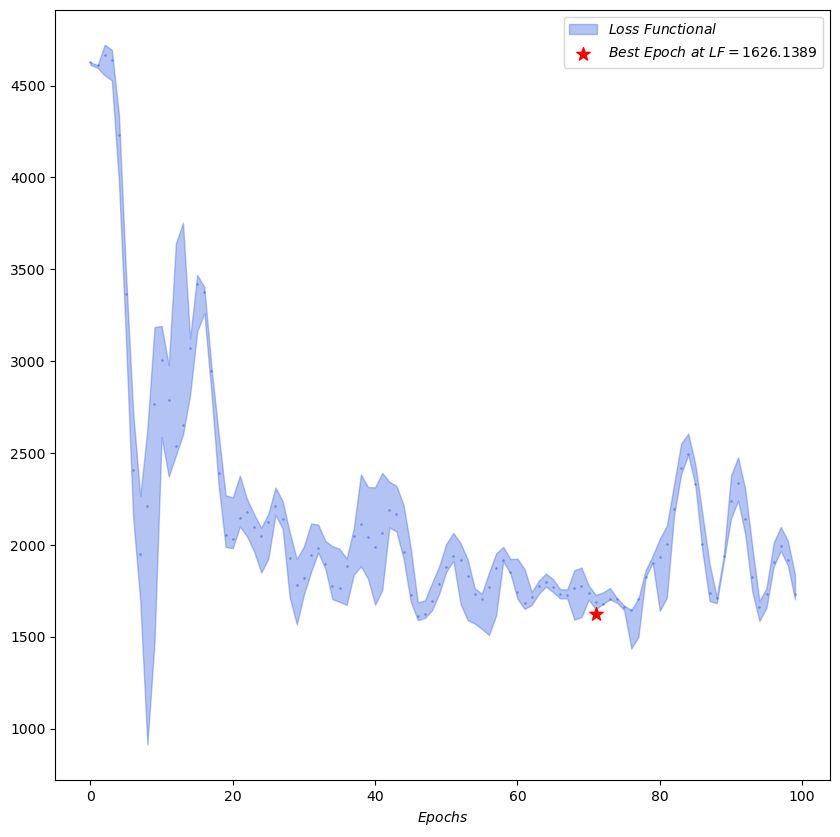

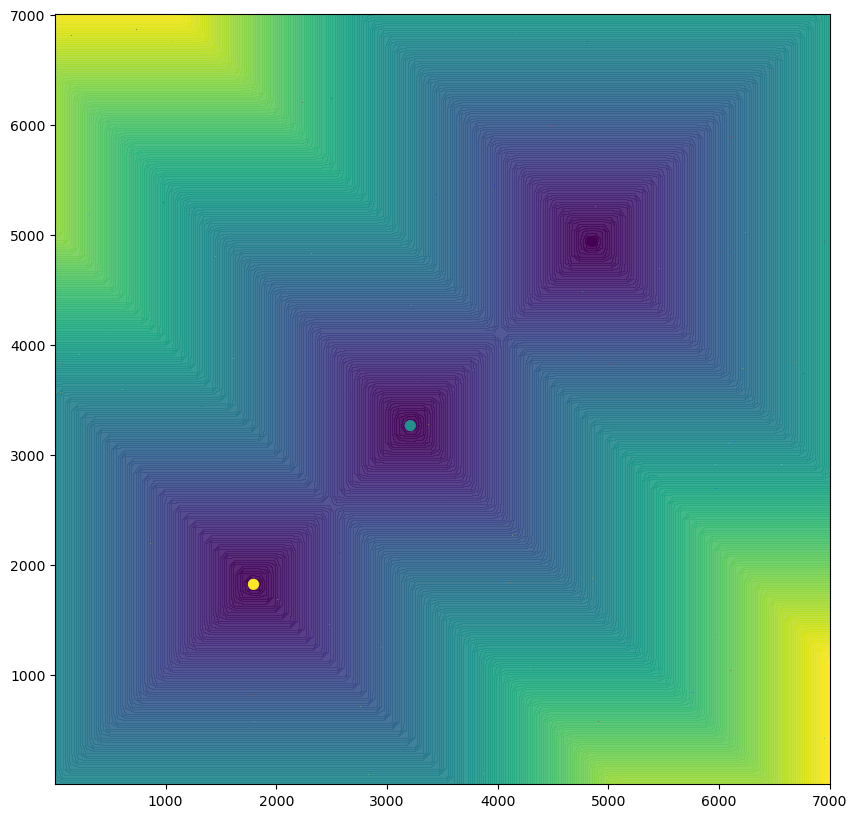

getUncertaintyArea
Centroids are [[4851.008  4940.616 ]
 [3210.2043 3268.756 ]
 [1793.7977 1827.5538]]
scale is 7001
Processing...
flag is 762
m is 139
i is 900


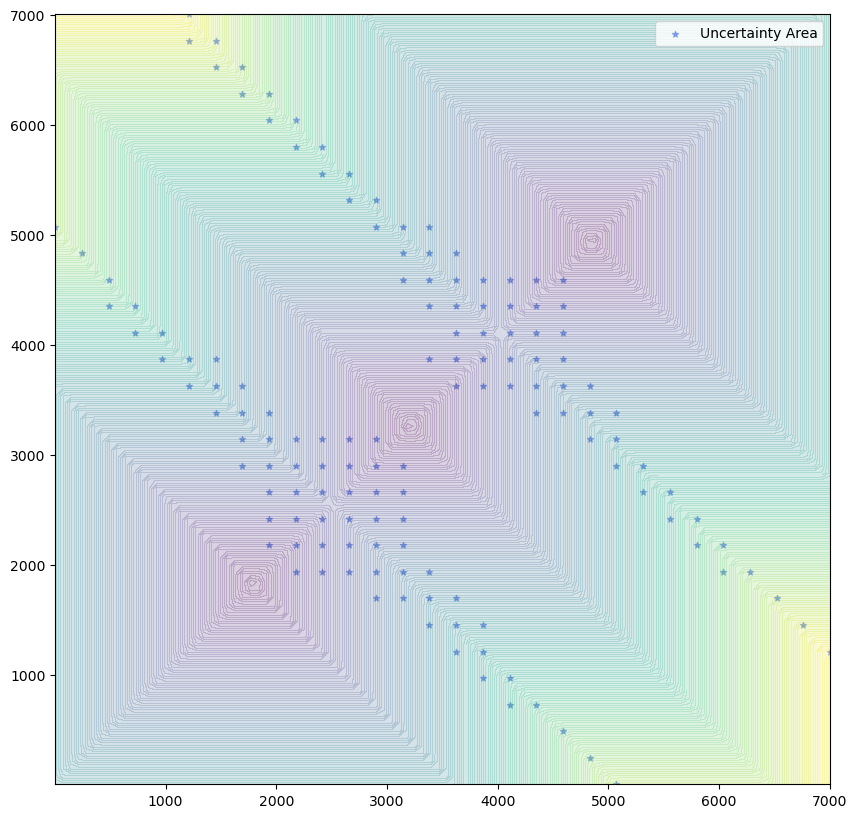

Labeled 0/139 points.
Labeled all 139/139 points.


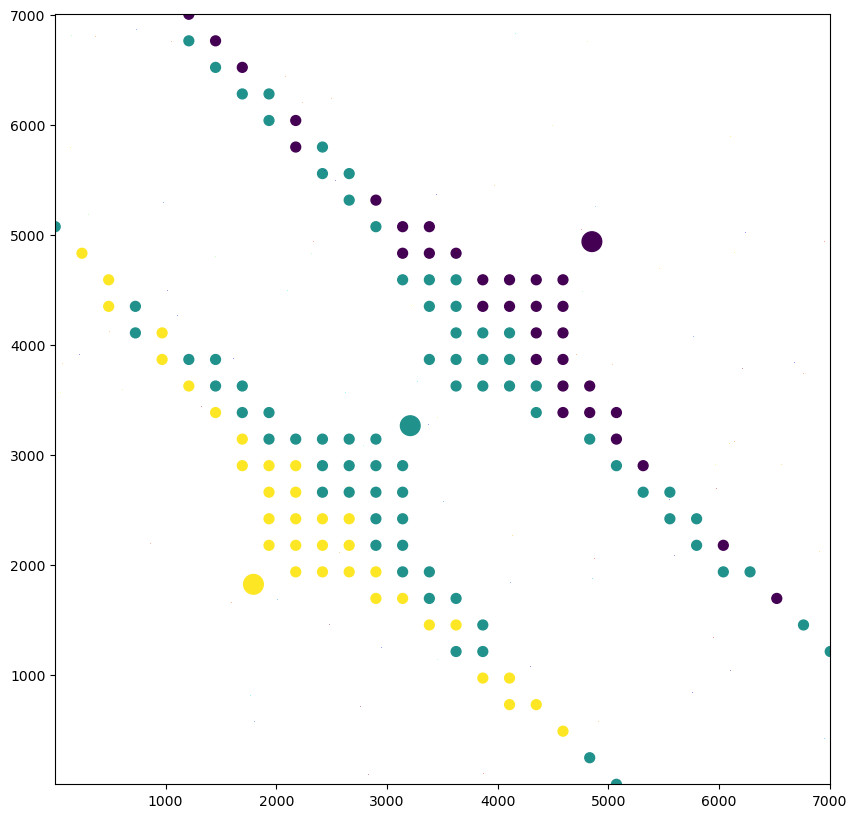

Creating critic for node 0 with 3 centroids.
Device is: cpu
Training Critic Model
Acc:  0.2446043165467626
Epoch:  0 Cost:  4892.91357421875
Acc:  0.6474820143884892
Epoch:  300 Cost:  92.68103790283203
Acc:  0.460431654676259
Epoch:  600 Cost:  113.81168365478516
Acc:  0.7553956834532374
Epoch:  900 Cost:  50.58568572998047
Acc:  0.8057553956834532
Epoch:  1200 Cost:  61.167972564697266
Acc:  0.8848920863309353
Epoch:  1500 Cost:  49.44442367553711
Acc:  0.8273381294964028
Epoch:  1800 Cost:  42.7924690246582
Acc:  0.7985611510791367
Epoch:  2100 Cost:  37.97578430175781
Acc:  0.8920863309352518
Epoch:  2400 Cost:  44.61612319946289
Acc:  0.8848920863309353
Epoch:  2700 Cost:  44.51786422729492
Saved critic config to ./models/squares/1000/demo0_critic_config.pt
Saved critic training results to ./models/squares/1000/demo0_critic_training_results.npy


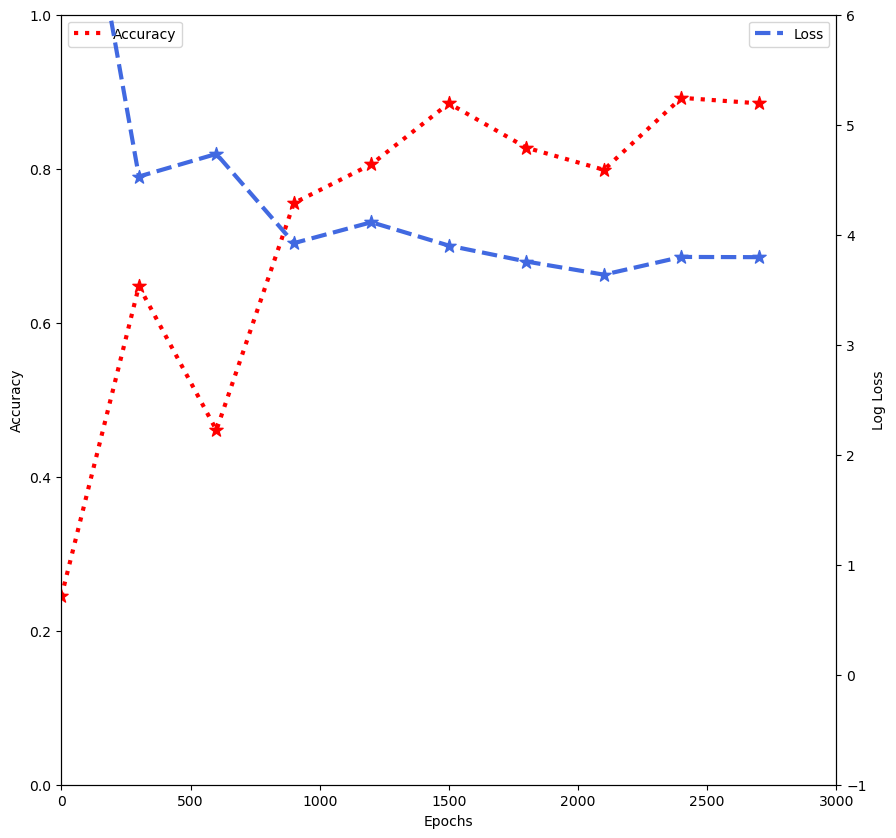


Creating critic for node 00 that has 336 data, which is more than the threshold 300.
Bounding box for node 00: [[1133, 7004], [1749, 7006]]
Creating clustering for node 00 with 3 centroids.
Training Clustering Model
Epoch: 10/100.. 
 Training loss: 2858.65479.. 
 torch.mean(F): 1954.18823.. 
 Reg Proj: 904.42119.. 
 Reg Latent: 0.04529.. 
 Repulsive: 0.00001.. 
 Memory: 195.41882.. 
 Memory: 195.41882.. 
 Output: 
 [[19418.936  33721.746 ]
 [ 3379.9858  5871.5073]
 [ 7345.637  12752.863 ]]
Epoch: 20/100.. 
 Training loss: 3115.08325.. 
 torch.mean(F): 3032.43555.. 
 Reg Proj: 82.60405.. 
 Reg Latent: 0.04381.. 
 Repulsive: 0.00003.. 
 Memory: 303.24355.. 
 Memory: 303.24355.. 
 Output: 
 [[4137.1294  2309.28   ]
 [-478.7086  -266.40643]
 [3000.466   1673.5573 ]]
Epoch: 30/100.. 
 Training loss: 2501.00244.. 
 torch.mean(F): 2344.60107.. 
 Reg Proj: 156.35862.. 
 Reg Latent: 0.04261.. 
 Repulsive: 0.00001.. 
 Memory: 234.46011.. 
 Memory: 234.46011.. 
 Output: 
 [[ 6314.4194  8517.234 

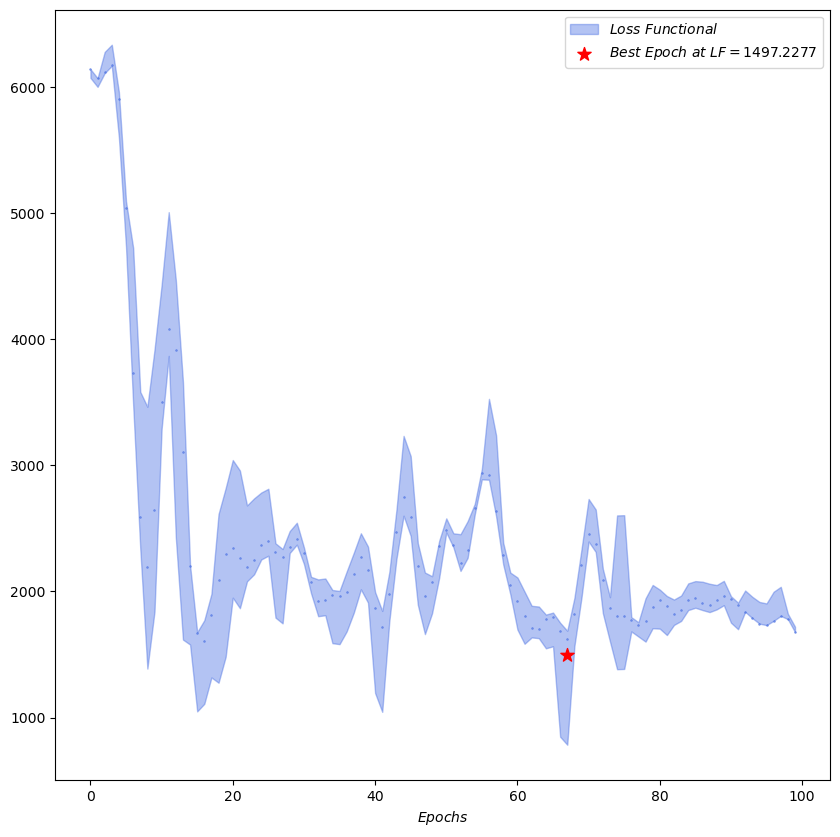

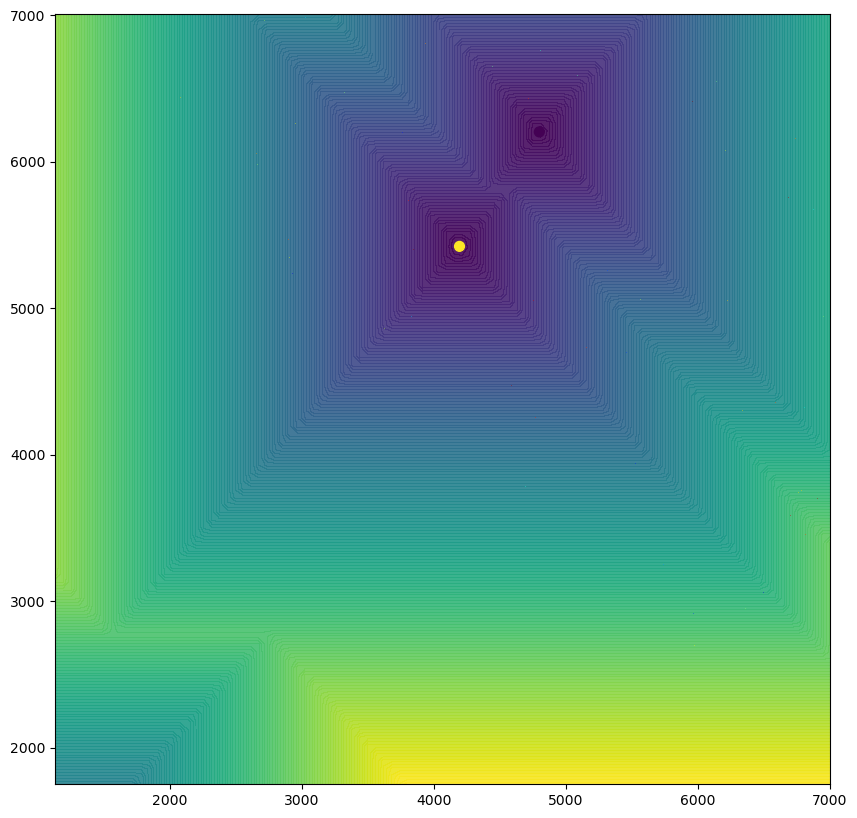

getUncertaintyArea
Centroids are [[4800.3125 6202.8647]
 [4195.5903 5421.4365]]
scale is 5871
Processing...
flag is 769
m is 132
i is 900


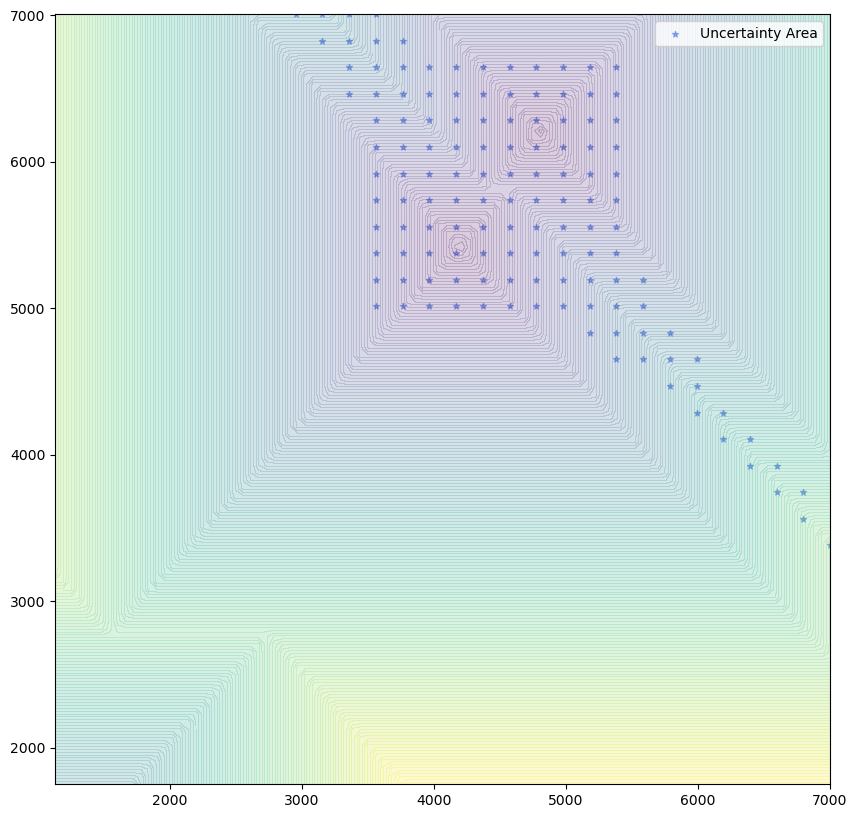

Labeled 0/132 points.
Labeled all 132/132 points.


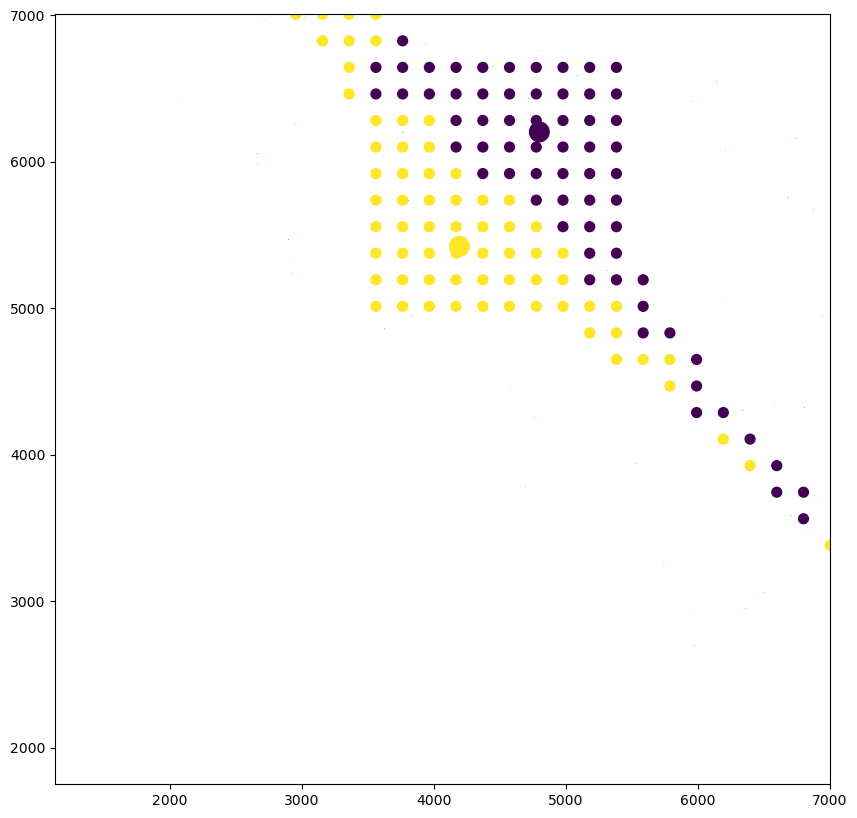

Creating critic for node 00 with 2 centroids.
Device is: cpu
Training Critic Model
Acc:  0.49242424242424243
Epoch:  0 Cost:  3008.562744140625
Acc:  0.6136363636363636
Epoch:  300 Cost:  61.38783645629883
Acc:  0.6666666666666666
Epoch:  600 Cost:  56.74126052856445
Acc:  0.6136363636363636
Epoch:  900 Cost:  65.35041046142578
Acc:  0.5909090909090909
Epoch:  1200 Cost:  57.33602523803711
Acc:  0.8484848484848485
Epoch:  1500 Cost:  52.016212463378906
Acc:  0.803030303030303
Epoch:  1800 Cost:  49.593292236328125
Acc:  0.6060606060606061
Epoch:  2100 Cost:  61.50260543823242
Acc:  0.7651515151515151
Epoch:  2400 Cost:  44.95701599121094
Acc:  0.7878787878787878
Epoch:  2700 Cost:  56.922115325927734
Saved critic config to ./models/squares/1000/demo00_critic_config.pt
Saved critic training results to ./models/squares/1000/demo00_critic_training_results.npy


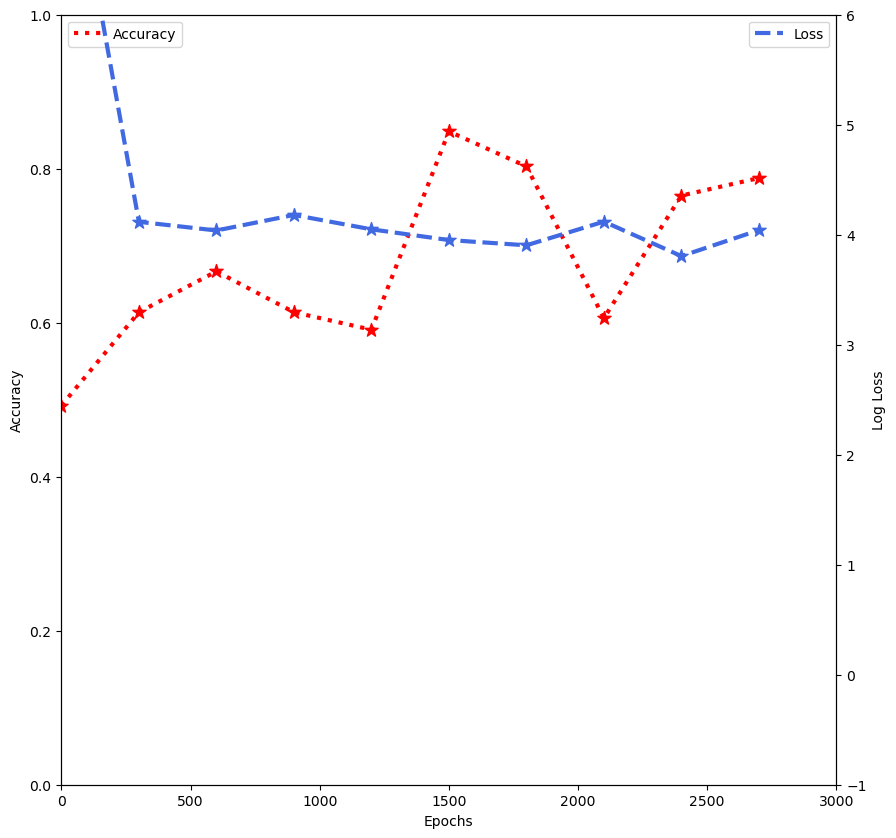


Creating critic for node 01 that has 401 data, which is more than the threshold 300.
Bounding box for node 01: [[71, 6962], [11, 6947]]
Creating clustering for node 01 with 3 centroids.
Training Clustering Model
Epoch: 10/100.. 
 Training loss: 3608.58521.. 
 torch.mean(F): 3596.48657.. 
 Reg Proj: 12.02990.. 
 Reg Latent: 0.06877.. 
 Repulsive: 0.00003.. 
 Memory: 359.64866.. 
 Memory: 359.64866.. 
 Output: 
 [[5111.9956  6533.1284 ]
 [-113.01253 -144.30153]
 [ 769.34814  982.988  ]]
Epoch: 20/100.. 
 Training loss: 1932.53833.. 
 torch.mean(F): 1928.38928.. 
 Reg Proj: 4.07630.. 
 Reg Latent: 0.07267.. 
 Repulsive: 0.00017.. 
 Memory: 192.83893.. 
 Memory: 192.83893.. 
 Output: 
 [[1457.1476 1388.6768]
 [1301.1622 1239.4177]
 [3176.8262 3029.2703]]
Epoch: 30/100.. 
 Training loss: 2076.16162.. 
 torch.mean(F): 1933.40149.. 
 Reg Proj: 142.68385.. 
 Reg Latent: 0.07614.. 
 Repulsive: 0.00002.. 
 Memory: 193.34015.. 
 Memory: 193.34015.. 
 Output: 
 [[ 3793.5657  3227.5193]
 [ 6175.7 

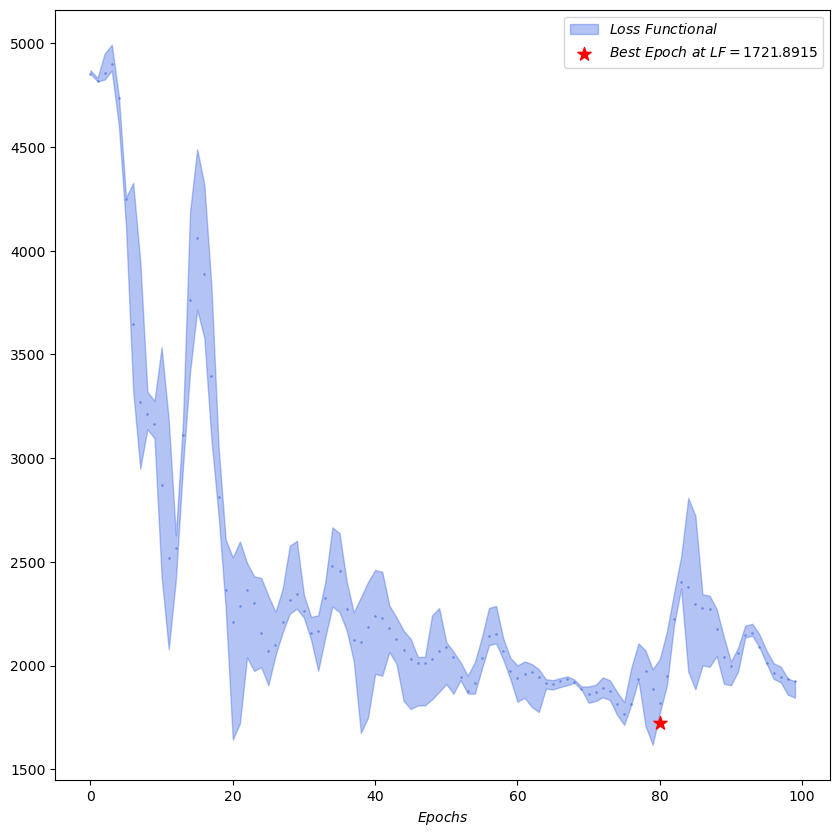

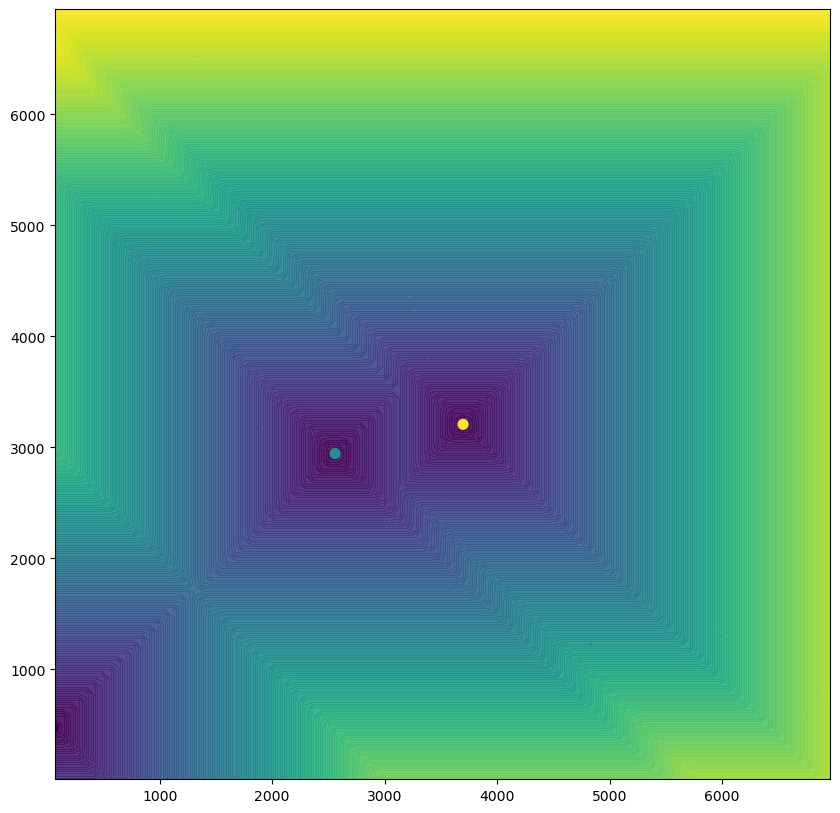

getUncertaintyArea
Centroids are [[2559.7573 2945.782 ]
 [3697.2402 3208.387 ]]
scale is 6936
Processing...
flag is 717
m is 184
i is 900


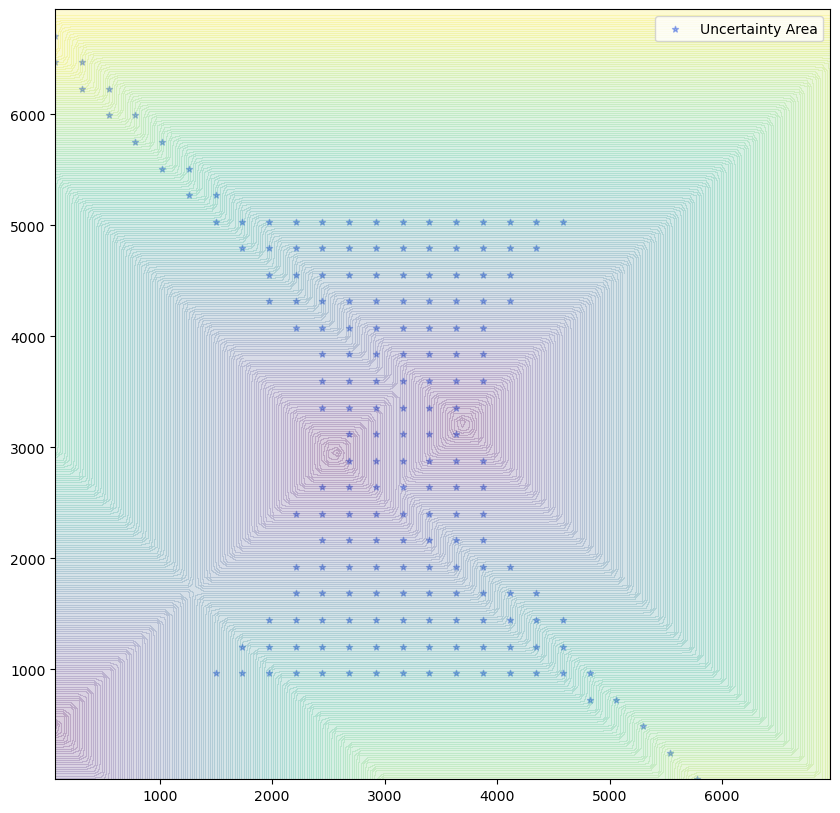

Labeled 0/184 points.
Labeled all 184/184 points.


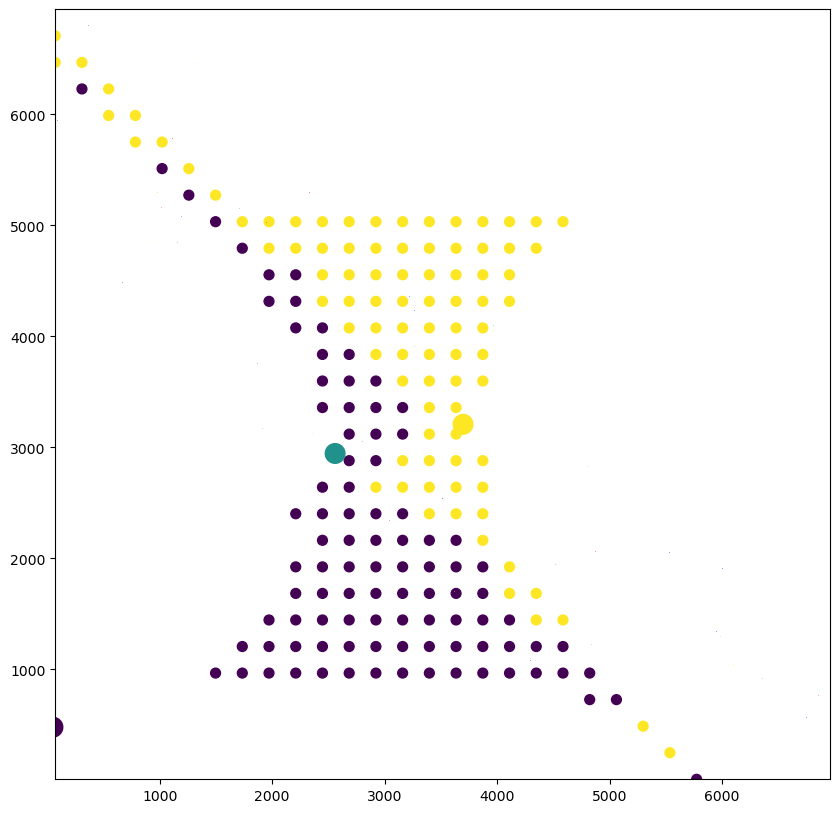

Creating critic for node 01 with 2 centroids.
Device is: cpu
Training Critic Model
Acc:  0.483695652173913
Epoch:  0 Cost:  3657.342041015625
Acc:  0.7554347826086957
Epoch:  300 Cost:  46.46598815917969
Acc:  0.8478260869565217
Epoch:  600 Cost:  45.955772399902344
Acc:  0.8152173913043478
Epoch:  900 Cost:  41.390987396240234
Acc:  0.8478260869565217
Epoch:  1200 Cost:  34.446067810058594
Acc:  0.8967391304347826
Epoch:  1500 Cost:  26.239660263061523
Acc:  0.8695652173913043
Epoch:  1800 Cost:  25.60936164855957
Acc:  0.875
Epoch:  2100 Cost:  32.090152740478516
Acc:  0.9021739130434783
Epoch:  2400 Cost:  25.76633071899414
Acc:  0.907608695652174
Epoch:  2700 Cost:  21.716632843017578
Saved critic config to ./models/squares/1000/demo01_critic_config.pt
Saved critic training results to ./models/squares/1000/demo01_critic_training_results.npy


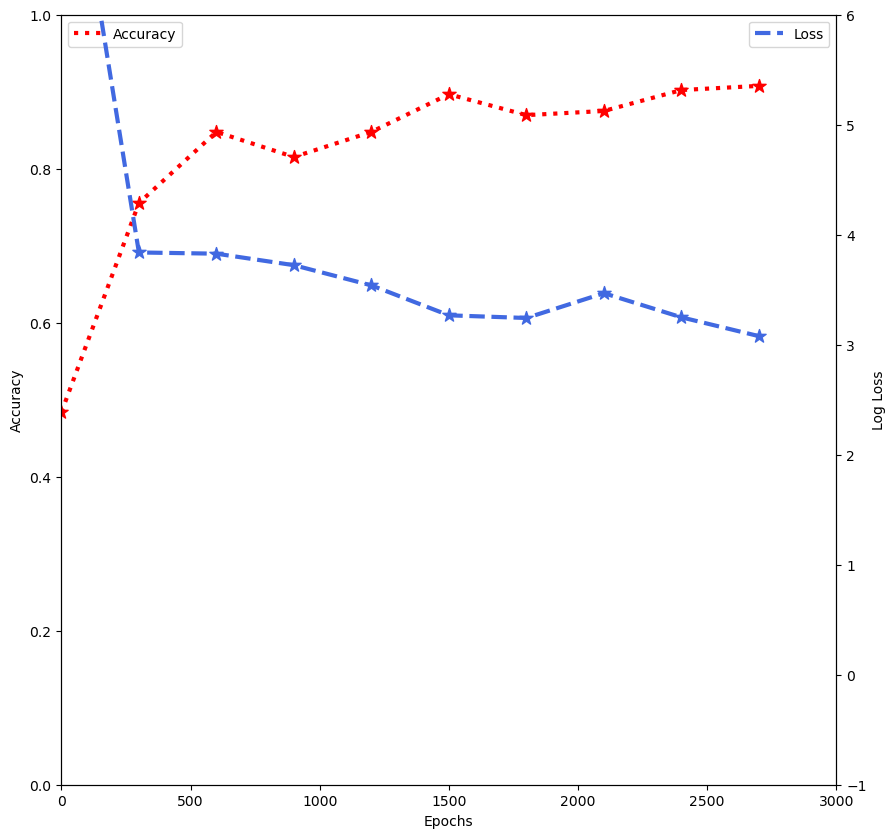

In [3]:
ktree.create_tree(save_path_prefix="./models/squares/1000/demo", plot=True)

### Load the k-tree from saved configuration

For a k-tree instance that is already trained and saved to configuration files (all existing in the same path and having the same prefix), load the instance by simply specifying that path and prefix. 

In [4]:
# The Critic's architecture arguments are still required.
critic_args = {
    "width": 200,
    "depth": 5,
}
threshold = 300
ktree = Ktree(threshold, data, Linf_simple, {}, {}, critic_args, device)
ktree.create_tree_from_config("./models/squares/1000/demo")

### k-tree stats

Report some tree stats like the total number of nodes, height, number of leaves and leaf sizes.

In [5]:
print(f"Tree node number is {ktree.number_of_nodes}")

leaves = ktree.get_leaves()

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)

Tree node number is 8
Tree height is 3.
Created 5 leaves with sizes
[121, 215, 142, 259, 262]


## Accuracy

We utilise three types of accuracy measures.
- accuracy of each individual Critic at each node
- accuracy of the tree per layer for random query points
- accuracy of the tree per layer for serialised query points

The root node is indexed as "0" and every child's index is prefixed by the index of its parent followed by the "child index", e.g. the 2nd child of the root has index "01". 

In [6]:
import numpy as np

np.random.seed(0)
n = 30
random_points = torch.zeros(n, ktree.dim)
space = ktree.root.get_bounding_box()
for i in range(n):
    random_points[i] = torch.tensor([np.random.uniform(space[d][0], space[d][1]) for d in range(ktree.dim)])
st_acc = ktree.get_critic_accuracies(random_points)

print(st_acc)

{'0': 0.8333333333333334, '00': 0.9333333333333333, '01': 0.8666666666666667}


In [7]:
acc.random_queries(ktree, n=300, times=4, k=3)

The number of queries per layer are:
[300. 190.]
The percentage of correct predictions per layer is:
[88. 83.]
The number of queries per layer are:
[300. 203.]
The percentage of correct predictions per layer is:
[91.         87.33333333]
The number of queries per layer are:
[300. 187.]
The percentage of correct predictions per layer is:
[86.         82.33333333]
The number of queries per layer are:
[300. 182.]
The percentage of correct predictions per layer is:
[84.33333333 80.33333333]
The mean percentage of correct predictions per layer is:
[87.33333333 83.25      ]


In [8]:
acc.serialised_queries(ktree, n=300, k=3)

The number of queries per layer are:
[289. 186.]
The percentage of correct predictions per layer is: 
[81.66666667 76.66666667]
